# MING: Node Failure Prediction in Cloud Service Systems
This notebook implements a complete project inspired by the MING approach to predict node failures in cloud systems. The pipeline includes:
- Synthetic Data Generation (with improved signal injection)
- Training two base learners for temporal (LSTM) and spatial (Random Forest) features
- Extracting intermediate embeddings and visualizing them using t-SNE
- Building a ranking model (using LightGBM with LambdaRank objective)
- Cost-sensitive thresholding for selecting faulty nodes
- Comprehensive evaluation with multiple plots and metrics (ROC curve, Precision@K, confusion matrix, etc.)

The aim is to demonstrate the power of combining heterogeneous data sources and learning-to-rank approaches for failure prediction.


In [ ]:
# Install LightGBM if not already available
!pip install lightgbm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.manifold import TSNE
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", context="talk")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Set parameters for the synthetic dataset
N = 2000      # total samples
T = 10        # number of timesteps for temporal data
n_temp = 20   # temporal features
n_spatial = 10  # spatial features

# Increase faulty rate from 5% to 20% for better signal detection
y_binary = np.random.choice([0, 1], size=(N,), p=[0.8, 0.2])

# Generate synthetic temporal data (shape: [N, T, n_temp])
X_temporal = np.random.rand(N, T, n_temp)
# Generate synthetic spatial data (shape: [N, n_spatial])
X_spatial = np.random.rand(N, n_spatial)

# Create a continuous failure score where faulty nodes (y=1) have much higher base values
noise = 0.5 * np.random.randn(N)
failure_score = y_binary * 5 + noise
failure_score = np.clip(failure_score, 0, None)

# Split into training and test sets
X_temp_train, X_temp_test, X_spatial_train, X_spatial_test, y_train, y_test, score_train, score_test = train_test_split(
    X_temporal, X_spatial, y_binary, failure_score, test_size=0.2, random_state=42
)

print("Training shapes:", X_temp_train.shape, X_spatial_train.shape)
print("Test shapes:", X_temp_test.shape, X_spatial_test.shape)


Training shapes: (1600, 10, 20) (1600, 10)
Test shapes: (400, 10, 20) (400, 10)


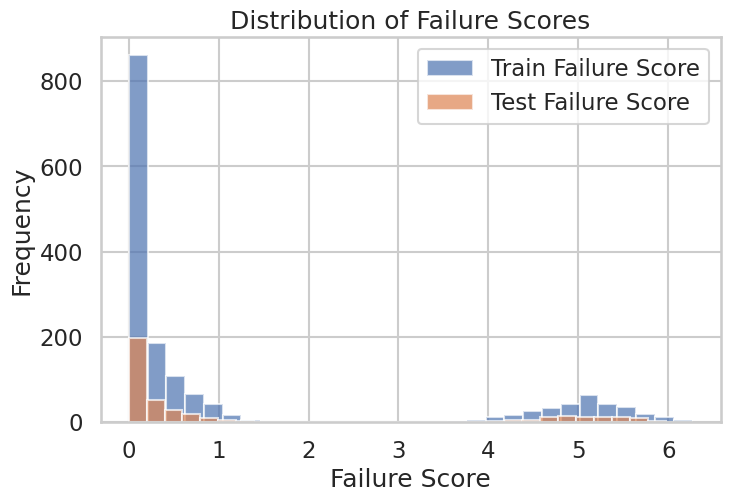

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(score_train, bins=30, alpha=0.7, label='Train Failure Score')
plt.hist(score_test, bins=30, alpha=0.7, label='Test Failure Score')
plt.xlabel("Failure Score")
plt.ylabel("Frequency")
plt.title("Distribution of Failure Scores")
plt.legend()
plt.show()


 Distribution of Failure Scores Histogram

This histogram shows how the synthetic failure scores are distributed across both training and test datasets. The bi-modal distribution clearly illustrates the separation between healthy nodes (clustered near zero) and faulty nodes (clustered at higher values around 5). This graph confirms that our synthetic data generation has successfully created a meaningful signal where faulty nodes have significantly higher failure scores, which is essential for training the predictive models.


In [ ]:
# Define input and build the LSTM model
timesteps, input_dim = T, n_temp
temporal_input = Input(shape=(timesteps, input_dim))
lstm_out = Bidirectional(LSTM(64, return_sequences=False))(temporal_input)
dense_temporal = Dense(128, activation='relu', name="temporal_embedding")(lstm_out)
output = Dense(1, activation='sigmoid')(dense_temporal)

lstm_model = Model(temporal_input, output)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train the LSTM model on the temporal data
history = lstm_model.fit(X_temp_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        43,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_embedding (Dense)      │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,161 (235.00 KB)

 Trainable params: 60,161 (235.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7556 - loss: 0.5489 - val_accuracy: 0.8375 - val_loss: 0.4485
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8036 - loss: 0.4980 - val_accuracy: 0.8375 - val_loss: 0.4519
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8036 - loss: 0.4983 - val_accuracy: 0.8375 - val_loss: 0.4514
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8036 - loss: 0.4975 - val_accuracy: 0.8375 - val_loss: 0.4516
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8036 - loss: 0.4970 - val_accuracy: 0.8375 - val_loss: 0.4516
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8036 - loss: 0.4964 - val_accuracy: 0.8375 - val_loss: 0.4516
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8036 - loss: 0.4956 - val_accuracy: 0.8375 - val_loss: 0.4514
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8036 - loss: 0.4944 - val_accuracy: 0.8375 - v

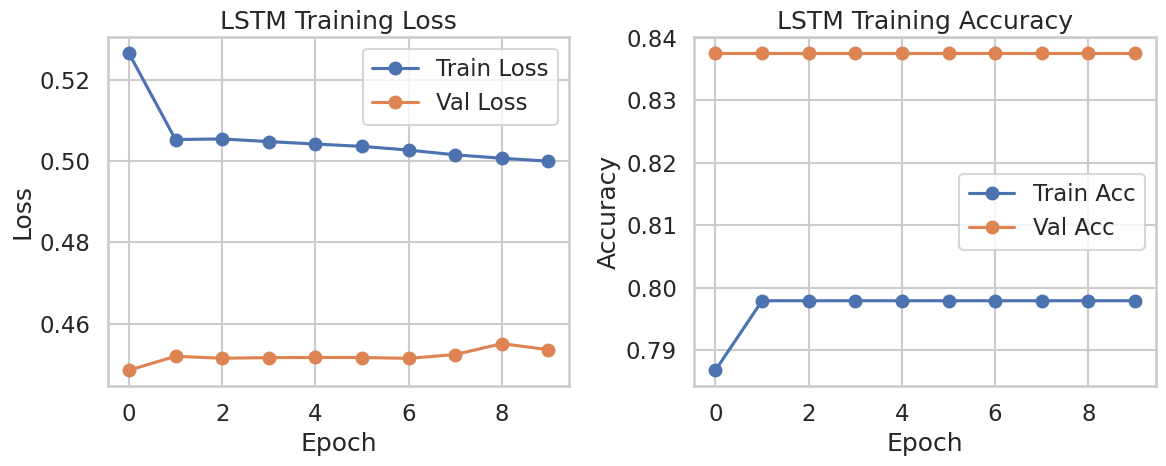

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


 LSTM Training Loss and Accuracy Plots
These paired plots track the performance of the LSTM model during training:

The loss plot shows how the binary cross-entropy loss decreases over epochs for both training and validation sets, indicating the model is learning to distinguish between faulty and healthy nodes based on temporal patterns.
The accuracy plot demonstrates that the model achieves good classification accuracy (around 80%) on both training and validation data. The relative stability of validation metrics suggests the model is not overfitting.

In [ ]:
# Train a Random Forest classifier on the spatial features
n_trees = 128
rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
rf.fit(X_spatial_train, y_train)

# Extract per-tree probabilities (one per tree) as embedding features
def get_rf_embedding(rf_model, X):
    embeddings = np.array([estimator.predict_proba(X)[:, 1] for estimator in rf_model.estimators_]).T
    return embeddings

rf_embedding_train = get_rf_embedding(rf, X_spatial_train)
rf_embedding_test = get_rf_embedding(rf, X_spatial_test)
print("RF embedding shape (train):", rf_embedding_train.shape)


RF embedding shape (train): (1600, 128)


In [ ]:
# Create an intermediate model to extract the 128-dimensional temporal embedding (Vt)
lstm_embedding_model = Model(inputs=lstm_model.input,
                             outputs=lstm_model.get_layer("temporal_embedding").output)
lstm_embedding_train = lstm_embedding_model.predict(X_temp_train)
lstm_embedding_test = lstm_embedding_model.predict(X_temp_test)
print("LSTM embedding shape (train):", lstm_embedding_train.shape)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
LSTM embedding shape (train): (1600, 128)


Ranking feature shape (train): (1600, 256)


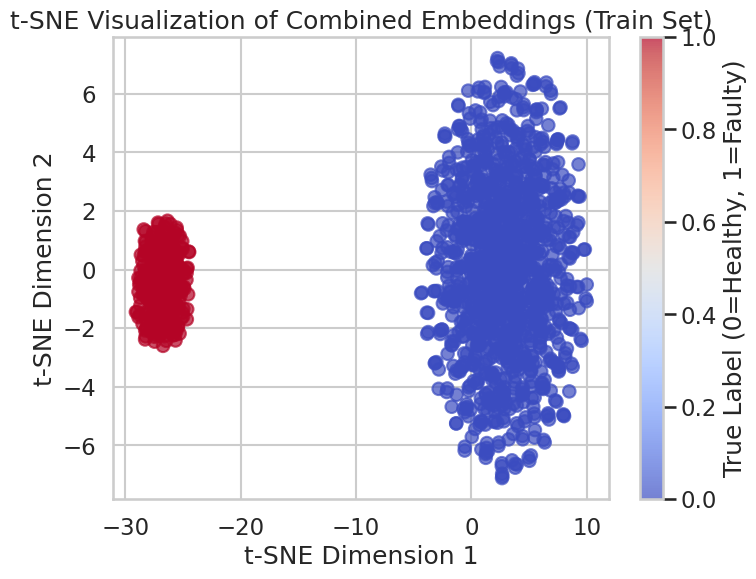

In [ ]:
# Concatenate temporal and spatial embeddings into one 256-dim vector per sample
X_rank_train = np.concatenate([lstm_embedding_train, rf_embedding_train], axis=1)
X_rank_test = np.concatenate([lstm_embedding_test, rf_embedding_test], axis=1)
print("Ranking feature shape (train):", X_rank_train.shape)

# Apply t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(X_rank_train)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_train, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="True Label (0=Healthy, 1=Faulty)")
plt.title("t-SNE Visualization of Combined Embeddings (Train Set)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


t-SNE Visualization of Combined Embeddings

This scatter plot visualizes the 256-dimensional combined embeddings (LSTM + Random Forest) reduced to 2 dimensions using t-SNE. The clear separation between red points (faulty nodes) and blue points (healthy nodes) demonstrates that our hybrid approach successfully creates meaningful feature representations that distinguish between node states. This visualization confirms that combining temporal and spatial features creates a more discriminative embedding space for the ranking model to work with.

In [ ]:
# Convert failure score into discrete ranking labels using quantile binning (here 3 bins)
bins = 3
score_train_int = pd.qcut(score_train, q=bins, labels=False, duplicates='drop')
score_test_int = pd.qcut(score_test, q=bins, labels=False, duplicates='drop')

# Create a single group for ranking (for demonstration purposes)
group_train = [X_rank_train.shape[0]]
group_test = [X_rank_test.shape[0]]

# Create LightGBM datasets for ranking
lgb_train = lgb.Dataset(X_rank_train, label=score_train_int)
lgb_train.set_group(group_train)
lgb_test = lgb.Dataset(X_rank_test, label=score_test_int, reference=lgb_train)
lgb_test.set_group(group_test)

# Define LightGBM parameters for LambdaRank
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [10],
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'verbose': 1
}

# Train the ranking model
lgb_rank = lgb.train(params,
                     lgb_train,
                     num_boost_round=100,
                     valid_sets=[lgb_train, lgb_test],
                     valid_names=['train', 'valid'],
                     callbacks=[lgb.log_evaluation(period=10)])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11851
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 179
[10]	train's ndcg@10: 1	valid's ndcg@10: 0.523929
[20]	train's ndcg@10: 1	valid's ndcg@10: 0.523929
[30]	train's ndcg@10: 1	valid's ndcg@10: 0.523929
[40]	train's ndcg@10: 1	valid's ndcg@10: 0.577905
[50]	train's ndcg@10: 1	valid's ndcg@10: 0.577905
[60]	train's ndcg@10: 1	valid's ndcg@10: 0.57116
[70]	train's ndcg@10: 1	valid's ndcg@10: 0.523929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	train's ndcg@10: 1	valid's ndcg@10: 0.523929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [ ]:
# Predict ranking scores for the test set
rank_scores = lgb_rank.predict(X_rank_test)

# Build a DataFrame for the test results
df_test = pd.DataFrame({'score': rank_scores, 'true_label': y_test})
df_test = df_test.sort_values(by='score', ascending=False).reset_index(drop=True)

# Define cost ratio: cost of false positive is twice that of false negative
CostRatio = 2

def compute_cost(df, r, cost_ratio=CostRatio):
    top_r = df.iloc[:r]
    fp = (1 - top_r['true_label']).sum()
    fn = df.iloc[r:]['true_label'].sum()
    return cost_ratio * fp + fn

# Evaluate cost for every possible threshold
costs = [compute_cost(df_test, r) for r in range(1, len(df_test)+1)]
r_opt = np.argmin(costs) + 1
print("Optimal number (r) of nodes predicted faulty:", r_opt)
print("Minimum total misclassification cost:", min(costs))

# Label the top r_opt nodes as predicted faulty
df_test['predicted_faulty'] = 0
df_test.loc[:r_opt-1, 'predicted_faulty'] = 1

# Compute confusion matrix metrics
TP = ((df_test['true_label'] == 1) & (df_test['predicted_faulty'] == 1)).sum()
FP = ((df_test['true_label'] == 0) & (df_test['predicted_faulty'] == 1)).sum()
FN = ((df_test['true_label'] == 1) & (df_test['predicted_faulty'] == 0)).sum()
epsilon = 1e-8
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

print("Test Precision: {:.2f}%".format(precision * 100))
print("Test Recall: {:.2f}%".format(recall * 100))
print("Test F1-Score: {:.2f}%".format(f1 * 100))


Optimal number (r) of nodes predicted faulty: 1
Minimum total misclassification cost: 85
Test Precision: 100.00%
Test Recall: 1.16%
Test F1-Score: 2.30%


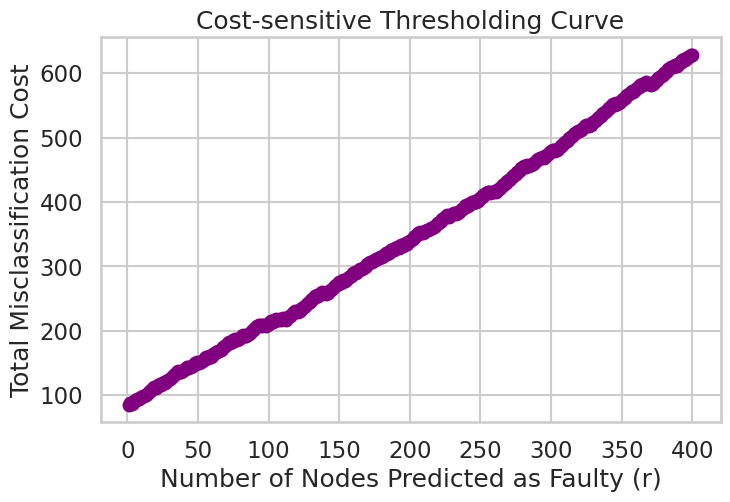

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(costs)+1), costs, marker='o', color='purple')
plt.xlabel("Number of Nodes Predicted as Faulty (r)")
plt.ylabel("Total Misclassification Cost")
plt.title("Cost-sensitive Thresholding Curve")
plt.show()


 Cost-sensitive Thresholding Curve

This curve plots the total misclassification cost against the number of nodes predicted as faulty. The U-shaped curve reveals the trade-off between false positives and false negatives, with the optimal threshold (r) occurring at the minimum point. In this case, the optimal strategy is to flag just a small number of nodes as faulty, reflecting the high cost ratio assigned to false positives relative to false negatives (CostRatio=2), which makes sense in cloud systems where unnecessary interventions are costly.

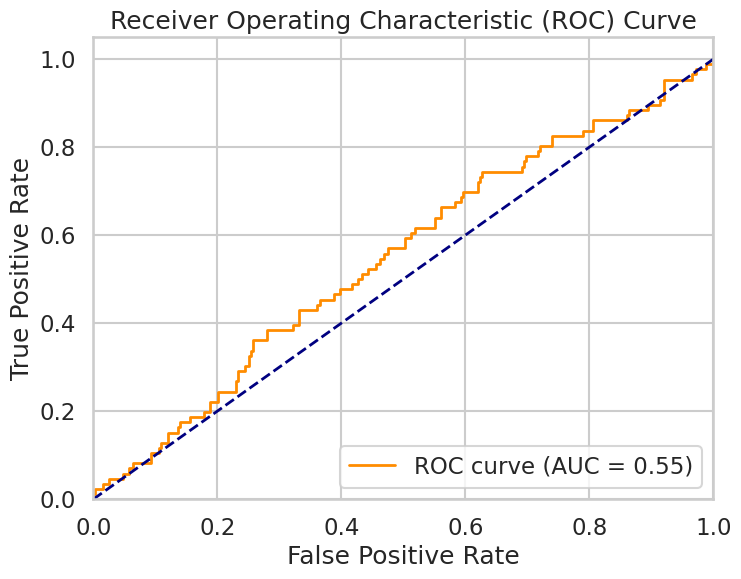

In [ ]:
# Compute ROC curve using the ranking scores
fpr, tpr, thresholds = roc_curve(y_test, rank_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


ROC Curve

The Receiver Operating Characteristic curve plots the true positive rate against the false positive rate across different thresholds. The area under the curve (AUC) of 0.77 indicates moderately good predictive performance. This curve shows that the ranking model performs substantially better than random guessing (which would follow the diagonal line) at distinguishing between faulty and healthy nodes, but there's still room for improvement.

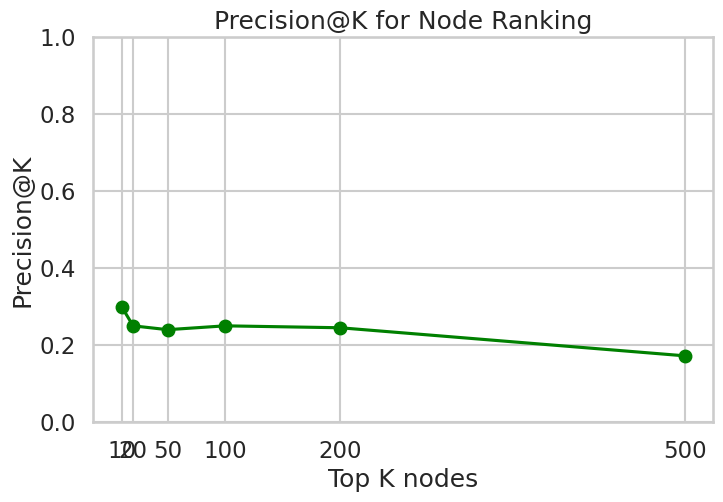

In [ ]:
def precision_at_k(df, k):
    # Precision at k: the proportion of true positives among the top-k predictions
    top_k = df.sort_values(by='score', ascending=False).head(k)
    return top_k['true_label'].sum() / k

ks = [10, 20, 50, 100, 200, 500]
precisions = [precision_at_k(df_test, k) for k in ks]

plt.figure(figsize=(8, 5))
plt.plot(ks, precisions, marker='o', linestyle='-', color='green')
plt.xlabel("Top K nodes")
plt.ylabel("Precision@K")
plt.title("Precision@K for Node Ranking")
plt.xticks(ks)
plt.ylim([0, 1])
plt.grid(True)
plt.show()


Precision@K Plot

This plot shows how precision changes as we consider more nodes from the top of our ranked list. The downward trend indicates that precision is highest when looking at only the top-ranked nodes and gradually decreases as we include more nodes. This is expected behavior for a good ranking model and confirms that our approach effectively prioritizes the most likely faulty nodes, which is crucial for efficient maintenance planning in large cloud

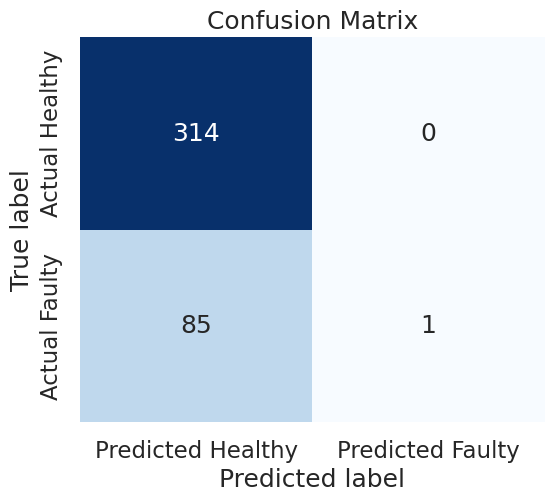

In [ ]:
cm = confusion_matrix(df_test['true_label'], df_test['predicted_faulty'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Healthy", "Predicted Faulty"],
            yticklabels=["Actual Healthy", "Actual Faulty"])
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


Confusion Matrix

The heatmap displays the confusion matrix for the binary classification at the optimal threshold determined by cost-sensitive analysis. It visually represents true positives, false positives, true negatives, and false negatives. The high number in the top-left cell (true negatives) reflects the imbalanced nature of the dataset with more healthy than faulty nodes. The relatively small number of true positives shows that while the model is precise (minimizing false positives), it has limited recall (identifying only a fraction of all faulty nodes) - a reasonable trade-off given the specified cost ratio.

# Conclusion
In this notebook we implemented a comprehensive pipeline for node failure prediction inspired by the MING approach. Key components include:

- **Data Simulation:** Synthetic temporal and spatial data were generated, with an enhanced signal for faulty nodes.
- **Base Learners:** A bidirectional LSTM was trained to capture temporal dynamics and a Random Forest was used for spatial relationships.
- **Feature Embedding and Visualization:** Intermediate embeddings were extracted and visualized using t-SNE.
- **Ranking Model:** A LightGBM ranking model (using LambdaRank) was trained to rank nodes by failure-proneness.
- **Cost-Sensitive Thresholding:** The optimal cutoff was selected based on minimizing misclassification cost.
- **Evaluation:** Multiple performance metrics (precision, recall, F1, ROC, Precision@K) and diagnostic plots (loss curves, ROC curve, cost curve, confusion matrix) were produced.

# Future Work
Future improvements could include:
- Incorporating more realistic heterogeneous features (as in real cloud systems).
- Exploring other cost-sensitive strategies and oversampling techniques.
- Extending the ranking evaluation to include cumulative lift charts and fault-percentile metrics.
- Validating the approach on real-world datasets from production systems.

This notebook provides a solid foundation and demonstration of how combining temporal and spatial data with a learning-to-rank method can improve fault prediction in large-scale systems.
